In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import typing
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.base import clone
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots

%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data preprocessing

In [4]:
class Chunk:
    def __init__(self, train_part, test_part, feature_names):
        self.train = train_part
        self.test = test_part
        self.features = feature_names
        
    def get_X(self, forvard_time):
        X = list(self.train.P1.values)
        X += list(self.train.P1_diff1.values)
        X += list(self.train.P1_diff2.values)
        X += list(self.train.P1_diff3.values)
        
        X += list(self.train.temperature.values)
        X += list(self.train.t_diff.values)
        X += list(self.train.t_diff1.values)
        X += list(self.train.t_diff2.values)
        
        #X += list(self.train.pressure.values)
        #X += list(self.train.p_diff.values)
        #X += list(self.train.p_diff1.values)
        #X += list(self.train.p_diff2.values)
        
        #X += list(self.train.humidity.values)
        #X += list(self.train.t_diff.values)
        #X += list(self.train.t_diff1.values)
        #X += list(self.train.t_diff2.values)
        
        return X
    
    def get_y(self, forward_time):
        y = self.test.P1.values[forward_time]
        return y

        
    def get_meta_X(self, forward_time, models):
        X = self.get_X(forward_time)
        model = models[forward_time]
        prediction = model.predict([X])[0]
        X_meta = [prediction]
        for feature in self.features:
            X_meta.append(self.test[feature].values[forward_time])
        return X_meta
        
        

In [5]:
def prepare_data(data):
    data['P1'] = data.P1.interpolate()
    
    data['pres_meteo'] = data.pres_meteo.fillna(method='bfill')
    data['temp_meteo'] = data.temp_meteo.fillna(method='bfill')
    data['hum_meteo'] = data.hum_meteo.fillna(method='bfill')
    data['pres_meteo'] = data.pres_meteo.interpolate()
    data['hum_meteo'] = data.hum_meteo.interpolate()
    data['temp_meteo'] = data.temp_meteo.interpolate()
    
    data['pressure'] = data.pressure.interpolate()
    data['humidity'] = data.humidity.interpolate()
    data['temperature'] = data.temperature.interpolate()
    
    data['prec_amount'] = data.prec_amount.fillna(method='bfill')
    data['prec_time'] = data.prec_time.fillna(method='bfill')
    data.loc[data.prec_amount == 'Осадков нет', 'prec_amount'] = 0
    data.loc[data.prec_amount == 'Следы осадков', 'prec_amount'] = 0
    data['prec_amount'] = data.prec_amount.astype(float)
    #data['prec_amount'] = data.prec_amount//data.prec_time
    data['prec_time'] = data.prec_time.interpolate()
    data['prec_amount'] = data.prec_amount.interpolate()
    data['wind_direction'] = data.wind_direction.fillna(method='bfill')
    return data

In [6]:
wind_dir = {'Ветер, дующий с востока': 0,
            'Ветер, дующий с востоко-северо-востока': 45/2,
            'Ветер, дующий с северо-востока': 45,
            'Ветер, дующий с северо-северо-востока': 45 + 45/2,
            'Ветер, дующий с севера': 90,
            'Ветер, дующий с северо-северо-запад': 90 + 45/2,
            'Ветер, дующий с северо-запада': 135,
            'Ветер, дующий с западо-северо-запада': 135 + 45/2,
            'Ветер, дующий с запада': 180,
            'Ветер, дующий с западо-юго-запада': 180+45/2,
            'Ветер, дующий с юго-запада': 225,
            'Ветер, дующий с юго-юго-запада': 225 + 45/2,
            'Ветер, дующий с юга': 270,
            'Ветер, дующий с юго-юго-востока': 270 + 45/2,
            'Ветер, дующий с юго-востока': 315,
            'Ветер, дующий с востоко-юго-востока': 315 + 45/2,
            'Штиль, безветрие': None,
            }

def add_features(data):
    data['day_of_week'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['sin_day'] = np.sin(2*np.pi*data.day_of_week/7)
    data['cos_day'] = np.cos(2*np.pi*data.day_of_week/7)
    data['sin_hour'] = np.sin(2*np.pi*data.hour/24)
    data['cos_hour'] = np.cos(2*np.pi*data.hour/24)
    
    data['P1_diff1'] = data.P1.diff(periods=1)
    data['P1_diff2'] = data.P1_diff1.diff(periods=1)
    data['P1_diff3'] = data.P1_diff2.diff(periods=1)
    data['t_diff'] = data.temperature.diff(periods=1)
    data['t_diff1'] = data.t_diff.diff(periods=1)
    data['t_diff2'] = data.t_diff1.diff(periods=1)
    data['p_diff'] = data.pressure.diff(periods=1)
    data['p_diff1'] = data.p_diff.diff(periods=1)
    data['p_diff2'] = data.p_diff1.diff(periods=1)
    data['h_diff'] = data.humidity.diff(periods=1)
    data['h_diff1'] = data.h_diff.diff(periods=1)
    data['h_diff2'] = data.h_diff1.diff(periods=1)
    
    data['wind_direction'] = data.wind_direction.map(wind_dir)
    data["wind_sin"] = np.sin(np.radians(data.wind_direction))
    data["wind_cos"] = np.cos(np.radians(data.wind_direction))
    data['wind_sin'] = data.wind_sin.fillna(value=2)
    data['wind_cos'] = data.wind_cos.fillna(value=2)
    
    data['temp_diff'] = data.temp_meteo.diff(periods=3)
    data['humidity_diff'] = data.hum_meteo.diff(periods=3)
    data['pressure_diff'] = data.pres_meteo.diff(periods=3)
    data['wind_sin_diff'] = data.wind_sin.diff(periods=3)
    data['wind_cos_diff'] = data.wind_cos.diff(periods=3)
    data['temp_diff3'] = data.temp_meteo.diff(periods=9)
    data['humidity_diff3'] = data.hum_meteo.diff(periods=9)
    data['pressure_diff3'] = data.pres_meteo.diff(periods=9)
    data['wind_sin_diff3'] = data.wind_sin.diff(periods=9)
    data['wind_cos_diff3'] = data.wind_cos.diff(periods=9)
    return data

In [7]:
data = pd.read_csv('../DATA/processed/dataset.csv', parse_dates=['date'])
data = data.set_index('date')

In [8]:
data.columns

Index(['P1', 'P2', 'pressure', 'temperature', 'humidity', 'temp_meteo',
       'pres_meteo', 'hum_meteo', 'wind_direction', 'wind_speed',
       'precipitation', 'prec_amount', 'prec_time', 'visibility',
       'dew_point_temp'],
      dtype='object')

In [9]:
sel_columns = ['P1', 'pres_meteo', 'temp_meteo', 'hum_meteo', 'wind_direction',
               'wind_speed', 'prec_amount', 'prec_time', 'pressure', 'temperature', 'humidity']
data = data[sel_columns]

In [10]:
data = prepare_data(data)
data = add_features(data)
data = data.resample('1H').mean()

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9193 entries, 2019-04-01 00:00:00+00:00 to 2020-04-18 00:00:00+00:00
Freq: H
Data columns (total 41 columns):
P1                9193 non-null float64
pres_meteo        9193 non-null float64
temp_meteo        9193 non-null float64
hum_meteo         9193 non-null float64
wind_direction    7562 non-null float64
wind_speed        9193 non-null float64
prec_amount       9193 non-null float64
prec_time         9193 non-null float64
pressure          9193 non-null float64
temperature       9193 non-null float64
humidity          9193 non-null float64
day_of_week       9193 non-null float64
hour              9193 non-null float64
sin_day           9193 non-null float64
cos_day           9193 non-null float64
sin_hour          9193 non-null float64
cos_hour          9193 non-null float64
P1_diff1          9193 non-null float64
P1_diff2          9193 non-null float64
P1_diff3          9193 non-null float64
t_diff            9193 non-null float

# Split data on chunks

In [12]:
train_data = data['2019-04-02 00:00:00+00:00':str(data.index[-1] - datetime.timedelta(days=50))]
test_data = data[str(data.index[-1] - datetime.timedelta(days=50)):]

In [13]:
def pp(start, end, n):
    """generation of random datetime indexes"""
    start_u = start.value//10**9
    end_u = end.value//10**9

    return pd.DatetimeIndex((10**9*np.random.randint(start_u, end_u, n)).view('M8[ns]'))

In [14]:
def generate_chunks(series, n, start, end, chunk_len, test_len, features):
    chunks = []
    for idx in pp(start, end, n):
        train_part = series[str(idx):str(idx+datetime.timedelta(hours=chunk_len-test_len))]
        test_part = series[str(idx+datetime.timedelta(hours=chunk_len-test_len)):str(idx+datetime.timedelta(hours=chunk_len))]
        chunk = Chunk(train_part, test_part, features)
        chunks.append(chunk)
    return chunks

In [15]:
chunk_len = 48
test_len = 24
train_start_idx = train_data.index[0]
train_end_idx = train_data.index[-1] - datetime.timedelta(hours=chunk_len)
train_num_samples = round(len(train_data)/3.2)
features = ['pres_meteo', 'temp_meteo', 'hum_meteo', 'wind_speed', 'prec_amount',
           'sin_day', 'cos_day', 'sin_hour', 'cos_hour', 'wind_sin', 'wind_cos', 'temp_diff', 'humidity_diff',
           'pressure_diff', 'temp_diff3', 'humidity_diff3',
           'pressure_diff3']
np.random.seed(42)

train_chunks = generate_chunks(train_data, train_num_samples,
                               train_start_idx, train_end_idx,
                               chunk_len, test_len, features)

test_start_idx = test_data.index[0]
test_end_idx = test_data.index[-1] - datetime.timedelta(hours=chunk_len)
test_num_samples = 300

test_chunks = generate_chunks(test_data, test_num_samples,
                              test_start_idx, test_end_idx,
                              chunk_len, test_len,
                              features)

In [16]:
train, train_meta = train_test_split(train_chunks, test_size=0.5, random_state=42)

# Train models

In [17]:
def train_models(model, chunks, num_models):
    models = []
    for i in range(num_models):
        X = [chunk.get_X(i) for chunk in chunks]
        local_model = clone(model)
        y = [chunk.get_y(i) for chunk in chunks]
        local_model.fit(X, y)
        models.append(local_model)
    return models

In [18]:
def get_mae(models, chunks):
    scores = []
    for i in range(len(models)):
        X = [chunk.get_X(i) for chunk in chunks]
        local_model = models[i]
        prediction = local_model.predict(X)
        y = [chunk.get_y(i) for chunk in chunks]
        mae = mean_absolute_error(y, prediction)
        scores.append(mae)
    return scores

In [19]:
%%time
#mod = RandomForestRegressor(min_samples_leaf=3, random_state=42)
mod = Lasso(alpha=0.9, random_state=42, max_iter=1500)
models = train_models(mod, train, test_len)

CPU times: user 12.5 s, sys: 2.43 s, total: 14.9 s
Wall time: 11.1 s


In [20]:
mae = get_mae(models, test_chunks)

In [21]:
alpha = [0.7, 0.8, 0.9, 1.0, 1.1]
for i in range(len(alpha)):
    mod = Lasso(alpha=alpha[i], random_state=42)
    models = train_models(mod, train, test_len)
    mae = get_mae(models, test_chunks)
    print(alpha[i], np.mean(mae))

0.7 6.84386090348362
0.8 6.841161092780869
0.9 6.840450066214462
1.0 6.841005691937447
1.1 6.841962594788825


In [22]:
mae, np.mean(mae)

([1.4971818056842243,
  2.6003898918161563,
  3.463994346296623,
  4.201294901542983,
  5.065957381648778,
  5.758724618600221,
  6.282612899579244,
  6.505998277294263,
  6.448943089672652,
  6.682944096664114,
  6.943784354185913,
  7.082958671368075,
  7.2698731748681835,
  7.606604398122527,
  7.837765377799684,
  8.062229253350187,
  8.198311188273482,
  8.312319371573572,
  8.521292326559427,
  8.807995520711502,
  9.10105557307678,
  9.183329857595318,
  9.30582534266272,
  9.465716555985155],
 6.841962594788825)

# Train meta models

In [23]:
def train_meta_models(meta_model, models, chunks, num_models):
    meta_models = []
    for i in range(num_models):
        X = [chunk.get_meta_X(i, models) for chunk in chunks]
        local_model = clone(meta_model)
        y = [chunk.get_y(i) for chunk in chunks]
        local_model.fit(X, y)
        meta_models.append(local_model)
    return meta_models

In [24]:
def get_meta_mae(models, meta_models, chunks):
    scores = []
    for i in range(len(models)):
        X = [chunk.get_meta_X(i, models) for chunk in chunks]
        local_model = meta_models[i]
        prediction = local_model.predict(X)
        y = [chunk.get_y(i) for chunk in chunks]
        mae = mean_absolute_error(y, prediction)
        scores.append(mae)
    return scores

In [25]:
def get_predictions(models, meta_models, chunk):
    predictions = []
    for i in range(len(models)):
        X = [chunk.get_meta_X(i, models) ]
        local_model = meta_models[i]
        prediction = local_model.predict(X)[0]
        predictions.append(prediction)
    return predictions

In [26]:
%%time
#meta_model = Lasso(alpha=0.2, random_state=42)
#meta_model = Ridge(alpha=0.6, random_state=42)
meta_model = RandomForestRegressor(min_samples_leaf=20, random_state=42)
meta_models = train_meta_models(meta_model, models, train_meta, test_len)

CPU times: user 24.1 s, sys: 179 ms, total: 24.3 s
Wall time: 25.9 s


In [27]:
meta_mae = get_meta_mae(models, meta_models, test_chunks)

In [28]:
def get_feature_impotances(models):
    importance = models[0].feature_importances_
    for mod in models[1:]:
        local_importance = mod.feature_importances_
        importance += local_importance
    importance = importance / len(models)
    return list(importance)

In [29]:
get_feature_impotances(meta_models)

[0.6578643194181041,
 0.01860193184259678,
 0.015140862067876787,
 0.16550290751333738,
 0.046950785136093964,
 0.03182510408516163,
 0.003418414501296574,
 0.0022489451438086404,
 0.005768804668780423,
 0.007961408934690094,
 0.006649038980029516,
 0.0366460660008402,
 0.0003521716924091336,
 0.00010955390785947317,
 0.00020515971799081397,
 0.00041741770397060187,
 0.0001395593750374486,
 0.00019754931011637547]

In [30]:
np.mean(meta_mae)

5.325696246291632

In [31]:
np.mean(meta_mae)

5.325696246291632

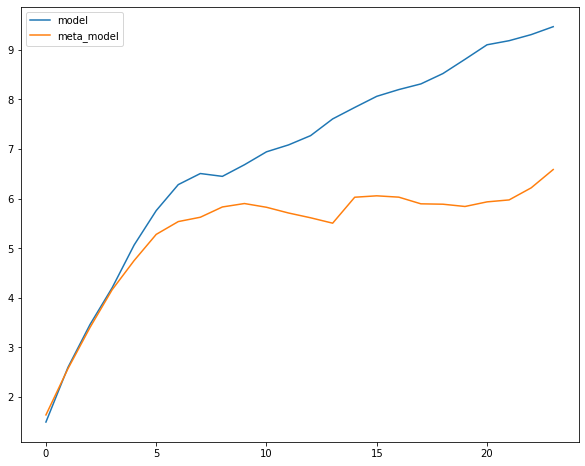

In [32]:
plt.plot(mae, label='model')
plt.plot(meta_mae, label='meta_model')
plt.legend()

In [33]:
mae, np.mean(mae)

([1.4971818056842243,
  2.6003898918161563,
  3.463994346296623,
  4.201294901542983,
  5.065957381648778,
  5.758724618600221,
  6.282612899579244,
  6.505998277294263,
  6.448943089672652,
  6.682944096664114,
  6.943784354185913,
  7.082958671368075,
  7.2698731748681835,
  7.606604398122527,
  7.837765377799684,
  8.062229253350187,
  8.198311188273482,
  8.312319371573572,
  8.521292326559427,
  8.807995520711502,
  9.10105557307678,
  9.183329857595318,
  9.30582534266272,
  9.465716555985155],
 6.841962594788825)

In [34]:
meta_mae, np.mean(meta_mae)

([1.640750653374844,
  2.5736579663562877,
  3.4048745922219865,
  4.162320439194604,
  4.7527243679558975,
  5.279433431393583,
  5.537443809968408,
  5.624987981491052,
  5.83209521445403,
  5.9011776213509135,
  5.82586592281622,
  5.710320873626677,
  5.613965602886446,
  5.505227929566664,
  6.0283402071506815,
  6.056611365974583,
  6.029793554920775,
  5.895418488745502,
  5.887616787233517,
  5.841736087071625,
  5.934688922750874,
  5.974127226269061,
  6.2170767661432995,
  6.586454098081639],
 5.325696246291632)

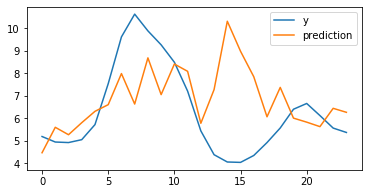

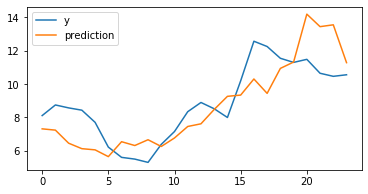

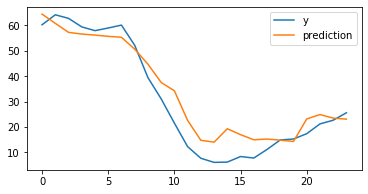

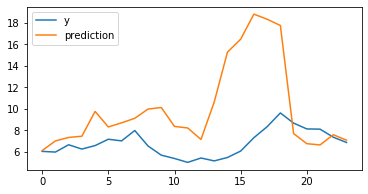

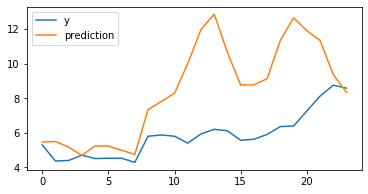

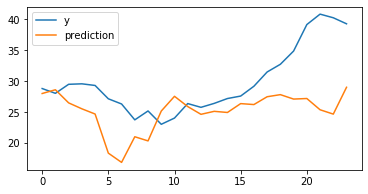

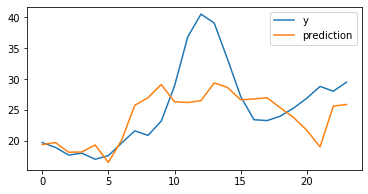

In [44]:
for chunk_num in [1, 34 ,53, 75, 166, 203, 42]:
    plt.figure(figsize=(6, 3))
    plt.plot([test_chunks[chunk_num].get_y(i) for i in range(len(meta_models))], label='y')
    plt.plot(get_predictions(models, meta_models, test_chunks[chunk_num]), label='prediction')
    plt.legend()